# Задание 4 - Перенос обучения (transfer learning) и тонкая настройка (fine-tuning)

Одной из важнейшних техник в тренировке сетей - использовать заранее натренированные веса на более общей задачи в качестве начальной точки, а потом "дотренировать" их на конкретной.

Такой подход и убыстряет обучение, и позволяет тренировать эффективные модели на маленьких наборах данных.

В этом упражнении мы натренируем классификатор, который отличает хотдоги от не хотдогов!  
(более подробно - https://www.youtube.com/watch?v=ACmydtFDTGs)

Это задание требует доступа к GPU, поэтому его можно выполнять либо на компьютере с GPU от NVidia, либо в [Google Colab](https://colab.research.google.com/).

In [1]:
import re
from collections import namedtuple
import math

import json
import os
import csv
import urllib
import PIL
from io import BytesIO
from PIL import Image

from socket import timeout

# from google.colab import files

# !pip3 install -q torch torchvision
# !pip3 install -q albumentations
# !pip3 install -q Pillow

Сначала давайте скачаем данные с картинками. Это сделает код в следующей ячейке. Данные будут разделены на две части. На обучающей выборке, которая будет храниться в папке **train_kaggle**, мы будем строить наши модели, а на тестовой выборке **test_kaggle** будем предсказывать класс, к которому относится фотография (хотдог или нет).

### Если вы в Google Colab!

В нем можно запускать ноутбуки с доступом к GPU. Они не очень быстрые, зато бесплатные!
Каждый ноутбук получает свой собственный environment c доступным диском итд.

Через 90 минут отсуствия активности этот environment пропадает со всеми данными.
Поэтому нам придется скачивать данные каждый раз.

In [2]:
# Download train data
# !wget "https://storage.googleapis.com/dlcourse_ai/train.zip"
# !unzip -q "train.zip"

train_folder = "train_kaggle/"
# Count number of files in the train folder, should be 4603
print('Number of files in the train folder', len(os.listdir(train_folder)))

# Download test data
# !wget "https://storage.googleapis.com/dlcourse_ai/test.zip"
# !unzip -q "test.zip"

test_folder = "test_kaggle/"
# Count number of files in the test folder, should be 1150
print('Number of files in the test folder', len(os.listdir(test_folder)))

Number of files in the train folder 4603
Number of files in the test folder 1150


In [3]:
import torch
from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0") # Let's make sure GPU is available!

In [4]:
def memory_stats(device):
    unit = 'MB'
    unit_denom = float(1024 * 1024)
    
    allocated = torch.cuda.memory_allocated(device) / unit_denom
    cached = torch.cuda.memory_cached(device) / unit_denom
    
    return f'<{device}> - allocated/cached: {allocated:.1f} {unit}/{cached:.1f} {unit}'

In [5]:
print(memory_stats(device))

<cuda:0> - allocated/cached: 0.0 MB/0.0 MB


In [38]:
debug = False

def print_debug(str):
    if debug:
        print(str)

# Сохраняем изображения в LMDB

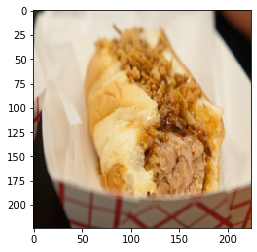

In [6]:
tmp = Image.open('train_kaggle/chili-dog_7572.jpg')
tmp = transforms.Resize((224, 224))(tmp)
tmp = Image.frombytes('RGB', (224, 224), tmp.tobytes())
plt.imshow(tmp);

In [7]:
import lmdb

std_shape = (224, 224)
resize_transform = transforms.Resize(std_shape)

def convert_to_lmdb(images_folder, lmdb_path):
    with lmdb_env = lmdb.open(lmdb_path, map_size=int(1024 * 1024 * 1024)):    
        with lmdb_env.begin(write=True) as txn:
            for name in sorted(os.listdir(images_folder)):
                image_name = os.path.join(images_folder, name)        
                image = Image.open(image_name)

                std_image = resize_transform(image)            

                key = name.encode('ascii')
                value = std_image.tobytes()

                txn.put(key, value)                

In [11]:
train_lmdb_path = 'train_lmdb'
test_lmdb_path = 'test_lmdb'

# convert_to_lmdb(train_folder, train_lmdb_path)
# convert_to_lmdb(test_folder, test_lmdb_path)

# Имплементируем свой Dataset для загрузки данных

В этом задании мы реализуем свой собственный класс Dataset для загрузки данных. Его цель - загрузить данные с диска и выдать по ним тензор с входом сети, меткой и идентификатором картинки (так будет проще подготовить сабмит для kaggle на тестовых данных).

Вот ссылка, где хорошо объясняется как это делать на примере: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

Ваш Dataset должен в качестве количества сэмплов выдать количество файлов в папке и уметь выдавать кортеж из сэмпла, метки по индексу и названия файла.
Если название файла начинается со слов 'frankfurter', 'chili-dog' или 'hotdog' - метка положительная. Иначе отрицательная (ноль).

И не забудьте поддержать возможность трансформации входа (аргумент `transforms`), она нам понадобится!

In [62]:
use_lmdb = True

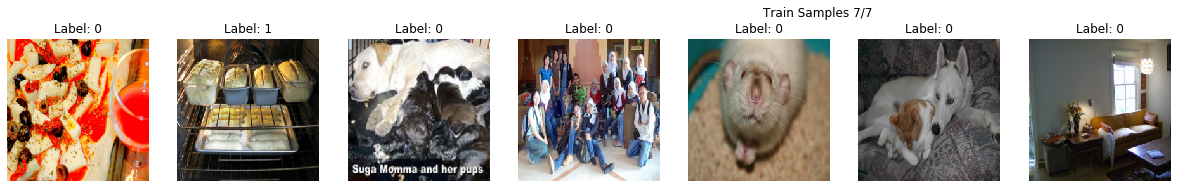

In [63]:
ImageMeta = namedtuple('ImageMeta', ['kind', 'num', 'name', 'hotdog'])

p = re.compile(r'^(?P<kind>.*?)(\_)?(?P<num>\d*)\.jpg$')
hotdog_kinds = set(['frankfurter', 'chili-dog', 'hotdog'])


class HotdogOrNotDataset(Dataset):
    def __init__(self, folder, lmdb_path, transform=None):
        self.transform = transform
        self.folder = folder
        self.lmdb_env = lmdb.open(lmdb_path,
                                  readonly=True, lock=False, meminit=False, readahead=False,
                                  map_size=int(1024 * 1024 * 1024))
        self.metadata = []
        
        for name in sorted(os.listdir(folder)):
            m = p.match(name)
            
            if m is None:
                raise Exception('Unexpected filename: <%s/%s>' % (folder, name))
                
            kind = m.group('kind')
            num = m.group('num')
                
            if kind == '':
                # test                                
                hotdog = -1
            else:
                # train
                hotdog = int((kind in hotdog_kinds))

            self.metadata.append(ImageMeta(kind, num, name, hotdog))
        
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, index):
        meta = self.metadata[index]
        
        if use_lmdb:
            with self.lmdb_env.begin(write=False) as txn:
                key = meta.name.encode('ascii')
                value = txn.get(key)            
                image = Image.frombytes('RGB', std_shape, value)
        else:
            filename = os.path.join(self.folder, meta.name)        
            image = Image.open(filename)
        
        if self.transform:
            image = self.transform(image)
            
        return image, meta.hotdog, meta.name
        

def visualize_samples(dataset, indices, title=None, count=10):
    # visualize random 10 samples
    plt.figure(figsize=(count * 3,3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))        
    for i, index in enumerate(display_indices):    
        x, y, _ = dataset[index]
        plt.subplot(1, count, i+1)
        plt.title("Label: %s" % y)
        plt.imshow(x)
        plt.grid(False)
        plt.axis('off')   
    
    
orig_train_dataset = HotdogOrNotDataset(train_folder, train_lmdb_path)
indices = np.random.choice(np.arange(len(orig_train_dataset)), 7, replace=False)
visualize_samples(orig_train_dataset, indices, "Train Samples")

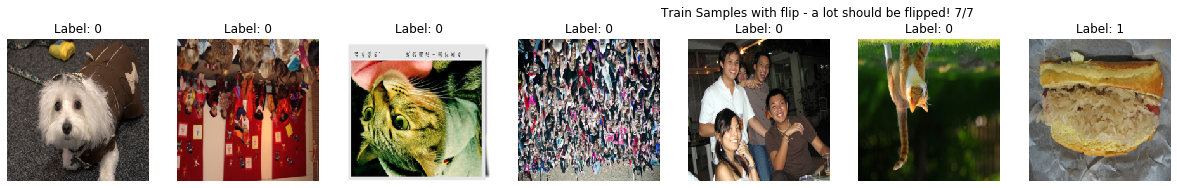

In [14]:
# Let's make sure transforms work!
train_flipped_dataset = HotdogOrNotDataset(train_folder, train_lmdb_path, transform=transforms.RandomVerticalFlip(0.9))
visualize_samples(train_flipped_dataset, indices, "Train Samples with flip - a lot should be flipped!")

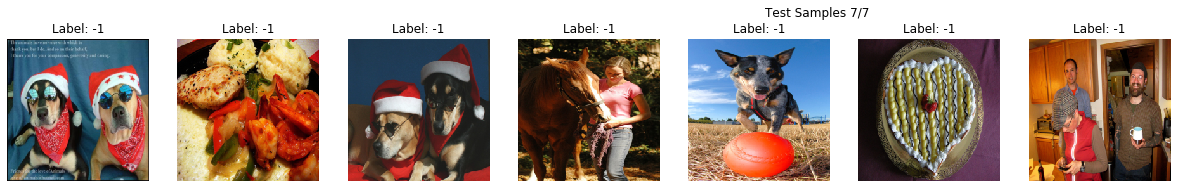

In [15]:
orig_test_dataset = HotdogOrNotDataset(test_folder, test_lmdb_path)
indices = np.random.choice(np.arange(len(orig_test_dataset)), 7, replace=False)
visualize_samples(orig_test_dataset, indices, "Test Samples")

# Создаем Dataset для тренировки

И разделяем его на train и validation.
На train будем обучать модель, на validation проверять ее качество, а соревнование Kaggle In-Class проведем на фотографиях из папки test_kaggle.

In [64]:
def lmdb_cond_resize_transform():
    if use_lmdb:
        return transforms.Lambda(lambda x: x)  # do nothing: lmdb already holds resized images
    else:
        return transforms.Resize((224, 224))




# First, lets load the dataset
train_dataset = HotdogOrNotDataset(train_folder, train_lmdb_path,
                       transform=transforms.Compose([
                           lmdb_cond_resize_transform(),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                         
                       ])
                      )
test_dataset = HotdogOrNotDataset(test_folder, test_lmdb_path,
                       transform=transforms.Compose([
                           lmdb_cond_resize_transform(),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                         
                       ])
                      )

In [65]:
data_size = len(train_dataset)
validation_fraction = .2

val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, sampler=train_sampler, num_workers=4, pin_memory=True)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, sampler=val_sampler, num_workers=4, pin_memory=True)

# Notice that we create test data loader in a different way. We don't have the labels.
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512)

# Использование заранее натренированной сети (pretrained network)

Чаще всего в качестве заранее натренированной сети используется сеть, натренированная на данных ImageNet с 1M изображений и 1000 классами.

PyTorch включает такие натренированные сети для различных архитектур (https://pytorch.org/docs/stable/torchvision/models.html)  
Мы будем использовать ResNet18.

Для начала посмотрим, что выдает уже натренированная сеть на наших картинках. То есть, посмотрим к какому из 1000 классов их отнесет сеть.

Запустите модель на 10 случайных картинках из датасета и выведите их вместе с классами с наибольшей вероятностью.  
В коде уже есть код, который формирует соответствие между индексами в выходном векторе и классами ImageNet.

In [39]:
# Thanks to https://discuss.pytorch.org/t/imagenet-classes/4923/2
def load_imagenet_classes():
    classes_json = urllib.request.urlopen('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json').read()
    classes = json.loads(classes_json)
    
    return {int(k): v[-1] for k, v in classes.items()}


def visualize_predictions(model, model_dataset, orig_dataset, indices, classes, title=None, count=10):
    assert model_dataset.metadata == orig_dataset.metadata    
    
    plt.figure(figsize=(count * 3, 3))
    display_indices = indices[:count]
    
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))
        
    print_debug(f'model before predictions # {memory_stats(device)}')
    
    for i, index in enumerate(display_indices):
        print_debug(f'\tprediction [{i}] started # {memory_stats(device)}')
        
        x, _, _ = model_dataset[index]
        x_gpu = x.to(device)
        
        print_debug(f'\t\tx_gpu # {memory_stats(device)}')
        
        y_probs = model(torch.unsqueeze(x_gpu, 0))
        
        print_debug(f'\t\ty_probs # {memory_stats(device)}')
        
        y_hat = torch.argmax(y_probs, 1)
        
        print_debug(f'\t\ty_hat # {memory_stats(device)}')
        
        image, _, _ = orig_dataset[index]
        
        plt.subplot(1, count, i + 1)
        plt.title("Label: %s" % classes[float(y_hat)])
        plt.imshow(image)
        plt.grid(False)
        plt.axis('off')
        
        print_debug(f'\tprediction [{i}] finished # {memory_stats(device)}')
        
    print_debug(f'model after predictions # {memory_stats(device)}')

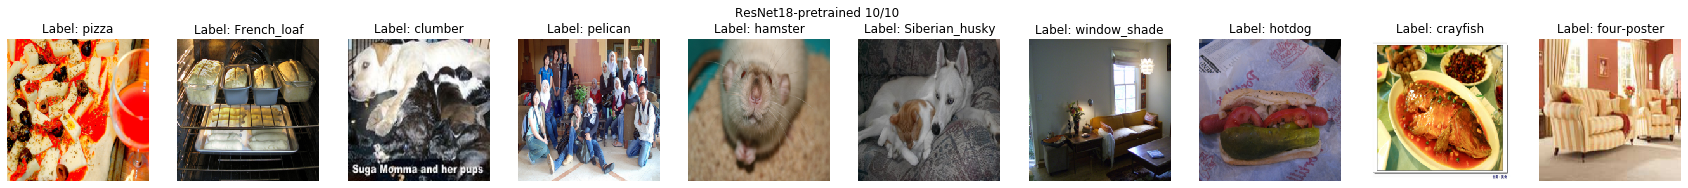

In [40]:
# Run this model on 10 random images of your dataset and visualize what it predicts

print_debug(f'start # {memory_stats(device)}')

model = models.resnet18(pretrained=True)
model.type(torch.cuda.FloatTensor)
model.to(device)

print_debug(f'model loaded # {memory_stats(device)}')

model.eval()

print_debug(f'model eval mode # {memory_stats(device)}')

classes = load_imagenet_classes()
indices = np.random.choice(np.arange(len(train_dataset)), 10, replace=False)
visualize_predictions(model, train_dataset, orig_train_dataset, indices, classes, "ResNet18-pretrained")

print_debug(f'predictions visualized # {memory_stats(device)}')

torch.cuda.empty_cache()

print_debug(f'cache emptied # {memory_stats(device)}')

del model

print_debug(f'model deleted # {memory_stats(device)}')

torch.cuda.empty_cache()

print_debug(f'cache emptied # {memory_stats(device)}')

## Train Function

In [44]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None, scheduler_loss=False):    
    train_loss_history = []
    train_acc_history = []

    val_loss_history = []
    val_acc_history = []
    
    print_debug(f'model before training # {memory_stats(device)}')
    
    for epoch in range(num_epochs):
        print_debug(f'\tepoch [{epoch}] started # {memory_stats(device)}')
        
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y, _) in enumerate(train_loader):
            print_debug(f'\t\ttraining step [{i_step}] started # {memory_stats(device)}')
            
            x_gpu = x.to(device)            
            print_debug(f'\t\t\tx_gpu # {memory_stats(device)}')
            
            y_gpu = y.to(device)            
            print_debug(f'\t\t\ty_gpu # {memory_stats(device)}')
            
            prediction = model(x_gpu)
            print_debug(f'\t\t\tprediction # {memory_stats(device)}')
                        
            loss_value = loss(prediction, y_gpu)
            print_debug(f'\t\t\tloss # {memory_stats(device)}')
            
            optimizer.zero_grad()
            print_debug(f'\t\t\tzero_grad # {memory_stats(device)}')
            
            loss_value.backward()
            print_debug(f'\t\t\tbackprop # {memory_stats(device)}')
            
            optimizer.step()
            print_debug(f'\t\t\toptimizer step # {memory_stats(device)}')
            
            indices = torch.argmax(prediction, 1)
            correct_samples += float(torch.sum(torch.eq(indices, y_gpu)))
            total_samples += float(y.shape[0])
            print_debug(f'\t\t\taccuracy accumulated # {memory_stats(device)}')
                        
            loss_accum += float(loss_value)
            print_debug(f'\t\t\tloss accumulated # {memory_stats(device)}')
            
            print_debug(f'\t\ttraining step [{i_step}] finished # {memory_stats(device)}')

        train_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        
        val_loss, val_accuracy = compute_loss_accuracy(model, val_loader)
        
        if scheduler is not None:
            if scheduler_loss:
                scheduler.step(val_loss)
            else:
                scheduler.step()
        
        train_loss_history.append(train_loss)
        train_acc_history.append(train_accuracy)        
        val_loss_history.append(val_loss)
        val_acc_history.append(val_accuracy)
        
        print_debug(f'\tepoch [{epoch}] finished # {memory_stats(device)}')
        
        print("Epoch #%s - train loss: %f, accuracy: %f | val loss: %f, accuracy: %f" % (epoch, train_loss, train_accuracy, val_loss, val_accuracy))
        
    print_debug(f'model after training # {memory_stats(device)}')
        
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history
       
    
def compute_loss_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    print_debug(f'\t\tcomputing loss & accuracy started # {memory_stats(device)}')
    
    model.eval() # Evaluation mode
    
    with torch.no_grad():    
        loss_accum = 0.0
        correct = 0.0
        total = 0.0
        for i, (x, y, _) in enumerate(loader):
            print_debug(f'\t\tvalidation step [{i}] started # {memory_stats(device)}')

            x_gpu = x.to(device)
            print_debug(f'\t\t\tx_gpu # {memory_stats(device)}')

            y_gpu = y.to(device)
            print_debug(f'\t\t\ty_gpu # {memory_stats(device)}')

            y_probs = model(x_gpu)        
            print_debug(f'\t\t\ty_probs # {memory_stats(device)}')

            y_hat = torch.argmax(y_probs, 1)
            print_debug(f'\t\t\ty_hat # {memory_stats(device)}')

            loss_value = loss(y_probs, y_gpu)
            print_debug(f'\t\t\tloss # {memory_stats(device)}')

            loss_accum += float(loss_value)
            print_debug(f'\t\t\tloss accumulated # {memory_stats(device)}')

            correct += float(torch.sum(y_hat == y_gpu))
            print_debug(f'\t\t\tcorrect instances accumulated # {memory_stats(device)}')

            total += y_gpu.shape[0]
            print_debug(f'\t\t\ttotal instances accumulated # {memory_stats(device)}')

            print_debug(f'\t\tvalidation step [{i}] finished # {memory_stats(device)}')
    
    print_debug(f'\t\tcomputing loss & accuracy finished # {memory_stats(device)}')
    
    return loss_accum / (i + 1), correct / total

# Перенос обучения (transfer learning) - тренировать только последний слой

Существует несколько вариантов переноса обучения, мы попробуем основные.  
Первый вариант - заменить последний слой на новый и тренировать только его, заморозив остальные.

In [45]:
import torch.nn as nn
import torch.optim as optim

# Freeze all the layers of this model and add a new output layer
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

print_debug(f'start # {memory_stats(device)}')

model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    
old_fc = model.fc
model.fc = nn.Linear(in_features=old_fc.in_features, out_features=2)

model.type(torch.cuda.FloatTensor)
model.to(device)

print_debug(f'model loaded # {memory_stats(device)}')

parameters = model.fc.parameters()

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(parameters, lr=0.001, momentum=0.9)

print_debug(f'training outside initiated # {memory_stats(device)}')
%time train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(model, train_loader, val_loader, loss, optimizer, 2)
print_debug(f'training outside completed # {memory_stats(device)}')

torch.cuda.empty_cache()
print_debug(f'cache emptied # {memory_stats(device)}')

# del model
# print_debug(f'model deleted # {memory_stats(device)}')

# del loss
# print_debug(f'loss deleted # {memory_stats(device)}')

# del optimizer
# print_debug(f'optimizer deleted # {memory_stats(device)}')

# del parameters
# print_debug(f'parameters deleted # {memory_stats(device)}')

# torch.cuda.empty_cache()
# print_debug(f'cache emptied # {memory_stats(device)}')


Epoch #0 - train loss: 0.599019, accuracy: 0.729840 | val loss: 0.377711, accuracy: 0.834783
Epoch #1 - train loss: 0.352514, accuracy: 0.849579 | val loss: 0.270579, accuracy: 0.885870
CPU times: user 6.08 s, sys: 2.05 s, total: 8.13 s
Wall time: 6.62 s


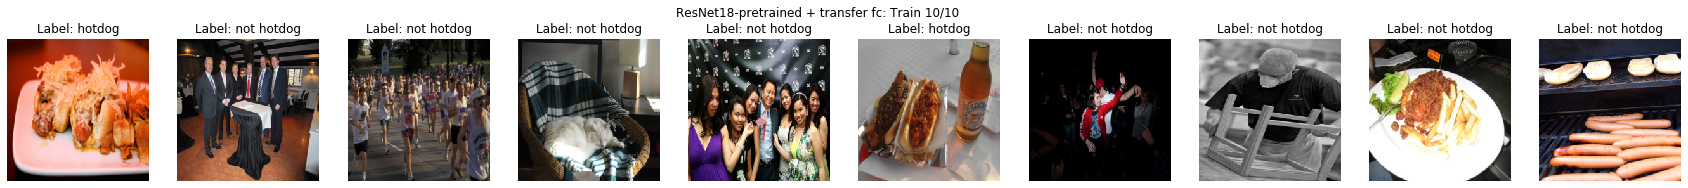

In [46]:
model.eval()

classes = {1: 'hotdog', 0: 'not hotdog'}
indices = np.random.choice(np.arange(len(train_dataset)), 10, replace=False)
visualize_predictions(model, train_dataset, orig_train_dataset, indices, classes, "ResNet18-pretrained + transfer fc: Train")

# Перенос обучения (transfer learning) - тренировать всю модель

Второй вариант - точно так же заменить последгний слой на новый и обучать всю модель целиком.

In [66]:
import torch.nn as nn
import torch.optim as optim

# Add a new output layer and train the whole model
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

print_debug(f'start # {memory_stats(device)}')

model = models.resnet18(pretrained=True)
    
old_fc = model.fc
model.fc = nn.Linear(in_features=old_fc.in_features, out_features=2)

model.type(torch.cuda.FloatTensor)
model.to(device)

print_debug(f'model loaded # {memory_stats(device)}')


parameters = model.parameters()

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(parameters, lr=0.001, momentum=0.9)

print_debug(f'training outside initiated # {memory_stats(device)}')
%time %prun train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(model, train_loader, val_loader, loss, optimizer, 5)
print_debug(f'training outside completed # {memory_stats(device)}')

torch.cuda.empty_cache()
print_debug(f'cache emptied # {memory_stats(device)}')

# del model
# print_debug(f'model deleted # {memory_stats(device)}')

# del loss
# print_debug(f'loss deleted # {memory_stats(device)}')

# del optimizer
# print_debug(f'optimizer deleted # {memory_stats(device)}')

# del parameters
# print_debug(f'parameters deleted # {memory_stats(device)}')

# torch.cuda.empty_cache()
# print_debug(f'cache emptied # {memory_stats(device)}')


Epoch #0 - train loss: 0.570597, accuracy: 0.703774 | val loss: 0.383289, accuracy: 0.823913
Epoch #1 - train loss: 0.288295, accuracy: 0.889492 | val loss: 0.222794, accuracy: 0.905435
Epoch #2 - train loss: 0.199563, accuracy: 0.926690 | val loss: 0.186418, accuracy: 0.931522
Epoch #3 - train loss: 0.167598, accuracy: 0.942710 | val loss: 0.170354, accuracy: 0.939130
Epoch #4 - train loss: 0.143274, accuracy: 0.949769 | val loss: 0.160939, accuracy: 0.942391
 CPU times: user 22.7 s, sys: 7.32 s, total: 30 s
Wall time: 30.6 s


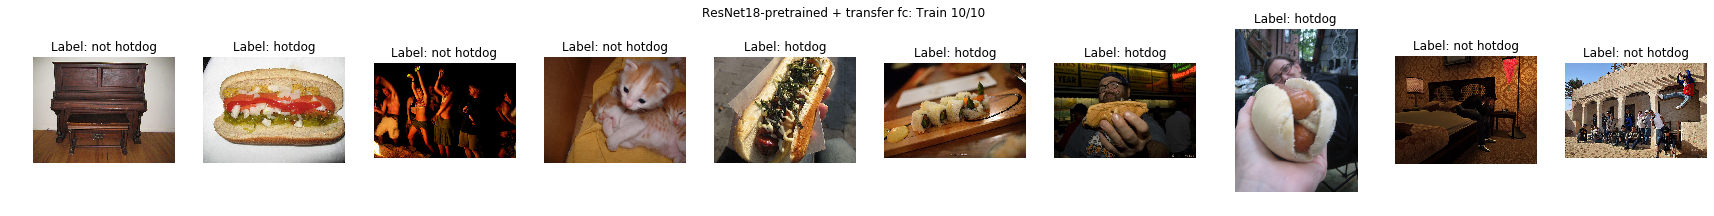

In [15]:
model.eval()

classes = {1: 'hotdog', 0: 'not hotdog'}
indices = np.random.choice(np.arange(len(train_dataset)), 10, replace=False)
visualize_predictions(model, train_dataset, orig_train_dataset, indices, classes, "ResNet18-pretrained + transfer fc: Train")

# Перенос обучения (transfer learning) - разные скорости обучения для разных слоев

И наконец последний вариант, который мы рассмотрим - использовать разные скорости обучения для новых и старых слоев

In [23]:
import torch.nn as nn
import torch.optim as optim

# Train new layer with learning speed 0.001 and old layers with 0.0001
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

model = models.resnet18(pretrained=True)
    
old_fc = model.fc
model.fc = nn.Linear(in_features=old_fc.in_features, out_features=2)

model.type(torch.cuda.FloatTensor)
model.to(device)


params_old = list([param for name, param in model.named_parameters() if not name.startswith('fc.')])
params_new = list([param for name, param in model.named_parameters() if name.startswith('fc.')])

loss = nn.CrossEntropyLoss()
parameters = [
    {'params': params_old, 'lr': 0.0001, 'momentum': 0.9},
    {'params': params_new, 'lr': 0.001, 'momentum': 0.9}
]
optimizer = optim.SGD(parameters)
%time train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(model, train_loader, val_loader, loss, optimizer, 5)


Epoch #0 - train loss: 0.349526, accuracy: 0.838447 | val loss: 0.209032, accuracy: 0.914130
Epoch #1 - train loss: 0.193985, accuracy: 0.926419 | val loss: 0.167633, accuracy: 0.935870
Epoch #2 - train loss: 0.160567, accuracy: 0.941895 | val loss: 0.152939, accuracy: 0.945652
Epoch #3 - train loss: 0.145930, accuracy: 0.945696 | val loss: 0.151107, accuracy: 0.944565
Epoch #4 - train loss: 0.138251, accuracy: 0.945696 | val loss: 0.140158, accuracy: 0.946739
CPU times: user 3min 50s, sys: 48.1 s, total: 4min 39s
Wall time: 4min 39s


# Визуализируем метрики и ошибки модели

Попробуем посмотреть, где модель ошибается - визуализируем ложные срабатывания (false positives) и ложноотрицательные срабатывания (false negatives).

Для этого мы прогоним модель через все примеры и сравним ее с истинными метками (ground truth).

In [0]:
from torch.utils.data.sampler import Sampler

class SubsetSampler(Sampler):
    """Samples elements with given indices sequentially

    Arguments:
        data_source (Dataset): dataset to sample from
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
        predictions: np array of booleans of model predictions
        ground_truth: np array of boolean of actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    predictions = []
    ground_truth = []
    
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=SubsetSampler(indices))    
    for (x, y, _) in loader:
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        
        y_probs = model(x_gpu)        
        y_hat = torch.argmax(y_probs, 1)
        
        predictions.append(y_hat.cpu().numpy())
        ground_truth.append(y.cpu().numpy())
        
    predictions = np.concatenate(predictions)
    ground_truth = np.concatenate(ground_truth)
    
    assert predictions.shape == ground_truth.shape
    assert predictions.size == ground_truth.size
    
    return predictions, ground_truth


predictions, gt = evaluate_model(model, train_dataset, val_indices)

И теперь можно визуализировать false positives и false negatives.

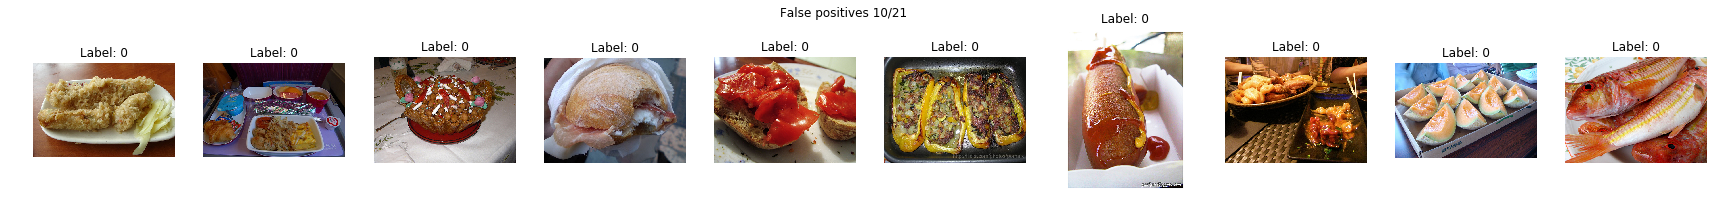

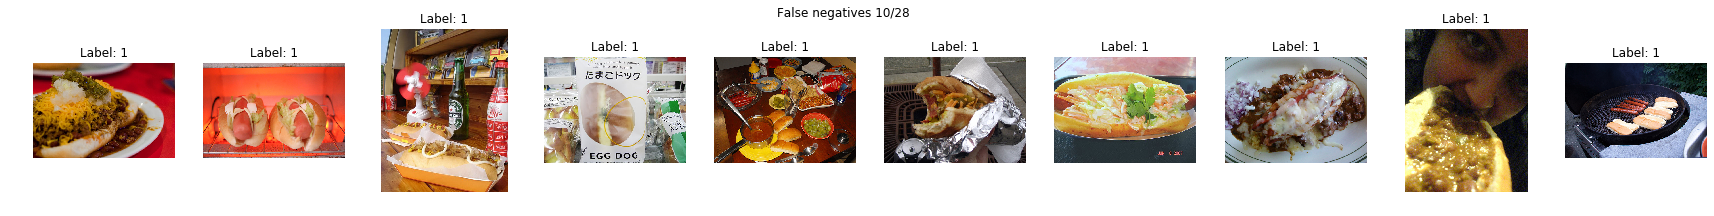

In [59]:
# Compute indices of the false positives on the validation set.
# Note those have to be indices of the original dataset
false_positive_pointers, = np.nonzero((predictions == 1) & (gt == 0))
false_positive_indices = np.array(val_indices)[false_positive_pointers]
visualize_samples(orig_train_dataset, false_positive_indices, "False positives")


# Compute indices of the false negatives on the validation set.
# Note those have to be indices of the original dataset
false_negatives_pointers, = np.nonzero((predictions == 0) & (gt == 1))
false_negatives_indices = np.array(val_indices)[false_negatives_pointers]
visualize_samples(orig_train_dataset, false_negatives_indices, "False negatives")


In [61]:
def binary_classification_metrics(prediction, ground_truth):
    """
    Computes metrics for binary classification

    Arguments:
        prediction, np array of int (num_samples) - model predictions
        ground_truth, np array of int (num_samples) - true labels

    Returns:
        precision, recall, f1, accuracy - classification metrics
    """

    tp = float(np.sum((prediction == 1) & (ground_truth == 1)))
    tn = float(np.sum((prediction == 0) & (ground_truth == 0)))
    fp = float(np.sum((prediction == 1) & (ground_truth == 0)))
    fn = float(np.sum((prediction == 0) & (ground_truth == 1)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    f1 = 2 * precision * recall / (precision + recall)

    return precision, recall, f1, accuracy

precision, recall, f1, accuracy = binary_classification_metrics(predictions, gt)
print("F1: %f, precision: %f, recall: %f, accuracy: %f" % (f1, precision, recall, accuracy))

F1: 0.920325, precision: 0.930921, recall: 0.909968, accuracy: 0.946739


# Что будет в конце вы уже поняли

Натренируйте лучшую модель на основе `resnet18`, меняя только процесс тренировки.
Выбирайте лучшую модель по F1 score.

Как всегда, не забываем:
- побольше агментаций!
- перебор гиперпараметров
- различные оптимизаторы
- какие слои тюнить
- learning rate annealing
- на какой эпохе останавливаться

Наша цель - довести F1 score на validation set до значения, большего **0.93**.

## F1 training function

In [0]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None, scheduler_loss=False):    
    train_loss_history = []
    train_acc_history = []

    val_loss_history = []
    val_acc_history = []
    val_f1_history = []
    
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y, _) in enumerate(train_loader):          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += float(loss_value)

        train_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        
        val_loss, val_accuracy, val_f1 = compute_loss_and_metrics(model, val_loader)
        
        if scheduler is not None:
            if scheduler_loss:
                scheduler.step(val_loss)
            else:
                scheduler.step()
        
        train_loss_history.append(train_loss)
        train_acc_history.append(train_accuracy)        
        val_loss_history.append(val_loss)
        val_acc_history.append(val_accuracy)
        val_f1_history.append(val_f1)
        
        print("Epoch #%s - train loss: %f, accuracy: %f | val loss: %f, accuracy: %f, f1: %f" % (epoch, train_loss, train_accuracy, val_loss, val_accuracy, val_f1))
        
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history, val_f1_history
       
    
def compute_loss_and_metrics(model, loader):
    model.eval() # Evaluation mode
    
    loss_accum = 0.0
    tp, tn, fp, fn = 0.0, 0.0, 0.0, 0.0
    
    for i, (x, y, _) in enumerate(loader):
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        
        y_probs = model(x_gpu)        
        y_hat = torch.argmax(y_probs, 1)
        
        # loss
        loss_value = loss(y_probs, y_gpu)
        loss_accum += float(loss_value)
        
        # metrics
        prediction = y_hat.cpu().numpy()
        ground_truth = y.cpu().numpy()
        
        tp += float(np.sum((prediction == 1) & (ground_truth == 1)))
        tn += float(np.sum((prediction == 0) & (ground_truth == 0)))
        fp += float(np.sum((prediction == 1) & (ground_truth == 0)))
        fn += float(np.sum((prediction == 0) & (ground_truth == 1)))
        
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    f1 = 2 * precision * recall / (precision + recall)
            
    return loss_accum / (i + 1), accuracy, f1

## F1 training with original data and simple model

In [82]:
model = models.resnet18(pretrained=True)
    
old_fc = model.fc
model.fc = nn.Linear(in_features=old_fc.in_features, out_features=2)

model.type(torch.cuda.FloatTensor)
model.to(device)


params_old = list([param for name, param in model.named_parameters() if not name.startswith('fc.')])
params_new = list([param for name, param in model.named_parameters() if name.startswith('fc.')])

loss = nn.CrossEntropyLoss()
parameters = [
    {'params': params_old, 'lr': 0.0001, 'momentum': 0.9},
    {'params': params_new, 'lr': 0.001, 'momentum': 0.9}
]
optimizer = optim.SGD(parameters)
%time train_loss_history, train_acc_history, val_loss_history, val_acc_history, val_f1_history = train_model(model, train_loader, val_loader, loss, optimizer, 15)

Epoch #0 - train loss: 0.398721, accuracy: 0.814553 | val loss: 0.219289, accuracy: 0.918478, f1: 0.872232
Epoch #1 - train loss: 0.189890, accuracy: 0.928591 | val loss: 0.181070, accuracy: 0.934783, f1: 0.898990
Epoch #2 - train loss: 0.161780, accuracy: 0.938637 | val loss: 0.157123, accuracy: 0.941304, f1: 0.910891
Epoch #3 - train loss: 0.148115, accuracy: 0.942981 | val loss: 0.153239, accuracy: 0.944565, f1: 0.919431
Epoch #4 - train loss: 0.134159, accuracy: 0.950041 | val loss: 0.144826, accuracy: 0.945652, f1: 0.919614
Epoch #5 - train loss: 0.129609, accuracy: 0.950041 | val loss: 0.137024, accuracy: 0.945652, f1: 0.917219
Epoch #6 - train loss: 0.125270, accuracy: 0.955200 | val loss: 0.136295, accuracy: 0.951087, f1: 0.927536
Epoch #7 - train loss: 0.111712, accuracy: 0.960087 | val loss: 0.141166, accuracy: 0.945652, f1: 0.916667
Epoch #8 - train loss: 0.115565, accuracy: 0.959001 | val loss: 0.131634, accuracy: 0.947826, f1: 0.922078
Epoch #9 - train loss: 0.095886, accu

## Augmentations

In [0]:
train_aug_dataset = HotdogOrNotDataset(train_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.RandomVerticalFlip(p=0.2),
                           transforms.RandomRotation(15, resample=PIL.Image.BILINEAR),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                         
                       ])
                      )


train_aug_viz_dataset = HotdogOrNotDataset(train_folder, 
                           transform=transforms.Compose([
                               transforms.Resize((224, 224)),
                               transforms.RandomHorizontalFlip(p=0.1),
                               transforms.RandomVerticalFlip(p=0.1),
                               transforms.RandomRotation(15, resample=PIL.Image.BILINEAR)                     
                           ])
                          )


assert len(train_aug_dataset) == len(train_dataset)
assert len(train_aug_viz_dataset) == len(train_dataset)

train_aug_loader = torch.utils.data.DataLoader(train_aug_dataset, batch_size=batch_size, sampler=train_sampler)
train_aug_viz_loader = torch.utils.data.DataLoader(train_aug_viz_dataset, batch_size=batch_size, sampler=train_sampler)

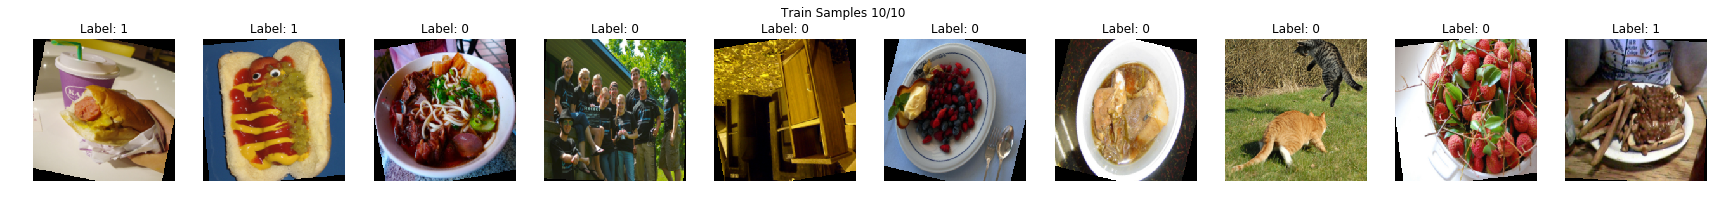

In [84]:
indices = np.random.choice(np.arange(len(train_aug_viz_dataset)), 10, replace=False)
visualize_samples(train_aug_viz_dataset, indices, "Train Samples")

## Augmentations training check

In [85]:
model = models.resnet18(pretrained=True)
    
old_fc = model.fc
model.fc = nn.Linear(in_features=old_fc.in_features, out_features=2)

model.type(torch.cuda.FloatTensor)
model.to(device)


params_old = list([param for name, param in model.named_parameters() if not name.startswith('fc.')])
params_new = list([param for name, param in model.named_parameters() if name.startswith('fc.')])

loss = nn.CrossEntropyLoss()
parameters = [
    {'params': params_old, 'lr': 0.0001, 'momentum': 0.9},
    {'params': params_new, 'lr': 0.001, 'momentum': 0.9}
]
optimizer = optim.SGD(parameters)
%time train_loss_history, train_acc_history, val_loss_history, val_acc_history, val_f1_history = train_model(model, train_aug_loader, val_loader, loss, optimizer, 15)

Epoch #0 - train loss: 0.375170, accuracy: 0.827043 | val loss: 0.211816, accuracy: 0.926087, f1: 0.890323
Epoch #1 - train loss: 0.216096, accuracy: 0.915015 | val loss: 0.181525, accuracy: 0.942391, f1: 0.915200
Epoch #2 - train loss: 0.190345, accuracy: 0.925604 | val loss: 0.166066, accuracy: 0.950000, f1: 0.925806
Epoch #3 - train loss: 0.175863, accuracy: 0.931578 | val loss: 0.159336, accuracy: 0.943478, f1: 0.913621
Epoch #4 - train loss: 0.174920, accuracy: 0.932392 | val loss: 0.161906, accuracy: 0.941304, f1: 0.914557
Epoch #5 - train loss: 0.177204, accuracy: 0.932935 | val loss: 0.153210, accuracy: 0.950000, f1: 0.924837
Epoch #6 - train loss: 0.158998, accuracy: 0.936193 | val loss: 0.153395, accuracy: 0.948913, f1: 0.922570
Epoch #7 - train loss: 0.145544, accuracy: 0.946783 | val loss: 0.154828, accuracy: 0.950000, f1: 0.925325
Epoch #8 - train loss: 0.136123, accuracy: 0.946783 | val loss: 0.164470, accuracy: 0.947826, f1: 0.923567
Epoch #9 - train loss: 0.144057, accu

## Hyperparams optimization

In [0]:
HyperParams = namedtuple("Hyperparams", ['learning_rate1', 'learning_rate2', 'reg_strength', 'anneal_factor', 'anneal_patience', 'epochs'])
RunResult = namedtuple("RunResult", ['model', 'train_loss_history', 'train_acc_history', 'val_loss_history', 'val_acc_history', 'val_f1_history', 'final_val_f1'])

In [0]:
# TODO: yeah, yeah, too much nesting – whatevers
def search(stats, learning_rates1, learning_rates2, reg_strengths, anneal_factors, anneal_patiences, epoch_nums):            
    for learning_rate1 in learning_rates1:
        for learning_rate2 in learning_rates2:
            for reg_strength in reg_strengths:
                for anneal_factor in anneal_factors:
                    for anneal_patience in anneal_patiences:
                        for epoch_num in epoch_nums:
                            
                            model = models.resnet18(pretrained=True)
    
                            old_fc = model.fc
                            model.fc = nn.Linear(in_features=old_fc.in_features, out_features=2)

                            model.type(torch.cuda.FloatTensor)
                            model.to(device)


                            params_old = list([param for name, param in model.named_parameters() if not name.startswith('fc.')])
                            params_new = list([param for name, param in model.named_parameters() if name.startswith('fc.')])

                            loss = nn.CrossEntropyLoss()
                            parameters = [
                                {'params': params_old, 'lr': learning_rate1},
                                {'params': params_new, 'lr': learning_rate2}
                            ]
                            
                            optimizer = optim.Adam(parameters, weight_decay=reg_strength)
                            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=anneal_factor, patience=anneal_patience, verbose=True)
                                 
                            key = HyperParams(learning_rate1, learning_rate2, reg_strength, anneal_factor, anneal_patience, epoch_num)
                                 
                            print('Training model: %s' % str(key))
                                 
                            results = train_model(model, train_aug_loader, val_loader, loss, optimizer, epoch_num, scheduler=scheduler, scheduler_loss=True)
                            train_loss_history, train_acc_history, val_loss_history, val_acc_history, val_f1_history = results
                            final_val_f1 = val_f1_history[-1]
                                 
                            value = RunResult(model, train_loss_history, train_acc_history, val_loss_history, val_acc_history, val_f1_history, final_val_f1)            
                            stats[key] = value
                                 
                            print('\n')

In [95]:
run_record = {}

learning_rates1 = [1e-4]
learning_rates2 = [5e-4]
reg_strengths = [1e-4]
anneal_factors = [0.333]
anneal_patiences = [3]
epoch_nums=[20]

search(run_record, learning_rates1, learning_rates2, reg_strengths, anneal_factors, anneal_patiences, epoch_nums)

run_record

Training model: Hyperparams(learning_rate1=0.0001, learning_rate2=0.0005, reg_strength=0.0001, anneal_factor=0.333, anneal_patience=3, epochs=20)
Epoch #0 - train loss: 0.196807, accuracy: 0.918002 | val loss: 0.162616, accuracy: 0.934783, f1: 0.897959
Epoch #1 - train loss: 0.092454, accuracy: 0.964974 | val loss: 0.202176, accuracy: 0.929348, f1: 0.903130
Epoch #2 - train loss: 0.054608, accuracy: 0.980722 | val loss: 0.183059, accuracy: 0.941304, f1: 0.909091
Epoch #3 - train loss: 0.034343, accuracy: 0.989411 | val loss: 0.149439, accuracy: 0.944565, f1: 0.918919
Epoch #4 - train loss: 0.028473, accuracy: 0.990225 | val loss: 0.205285, accuracy: 0.948913, f1: 0.922314
Epoch #5 - train loss: 0.039205, accuracy: 0.986967 | val loss: 0.152273, accuracy: 0.950000, f1: 0.926984
Epoch #6 - train loss: 0.036512, accuracy: 0.986153 | val loss: 0.213888, accuracy: 0.939130, f1: 0.903114
Epoch     7: reducing learning rate of group 0 to 3.3300e-05.
Epoch     7: reducing learning rate of grou

{Hyperparams(learning_rate1=0.0001, learning_rate2=0.0005, reg_strength=0.0001, anneal_factor=0.333, anneal_patience=3, epochs=20): RunResult(model=ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=

## Best model check

In [96]:
best_val_f1 = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_f1 is None or best_val_f1 < run_result.final_val_f1:
        best_val_f1 = run_result.final_val_f1
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation f1: %f, best hyperparams: %s" % (best_val_f1, best_hyperparams))

Best validation f1: 0.933333, best hyperparams: Hyperparams(learning_rate1=0.0001, learning_rate2=0.0005, reg_strength=0.0001, anneal_factor=0.333, anneal_patience=3, epochs=20)


F1: 0.933333, precision: 0.944079, recall: 0.922830, accuracy: 0.955435


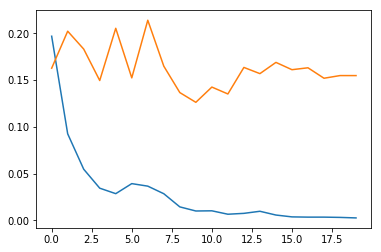

In [99]:
# Let's check how it performs on validation set!
predictions, ground_truth = evaluate_model(best_run.model, train_dataset, val_indices)
precision, recall, f1, accuracy = binary_classification_metrics(predictions, ground_truth)
print("F1: %f, precision: %f, recall: %f, accuracy: %f" % (f1, precision, recall, accuracy))


# Visualize training curve for the best model
plt.plot(best_run.train_loss_history)
plt.plot(best_run.val_loss_history);

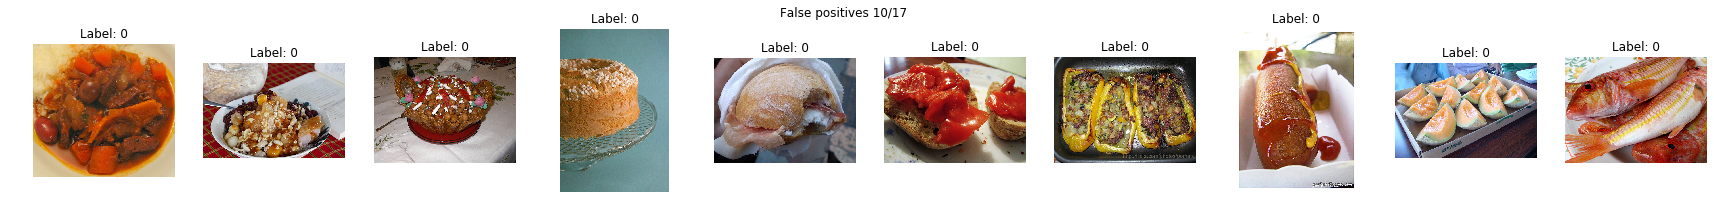

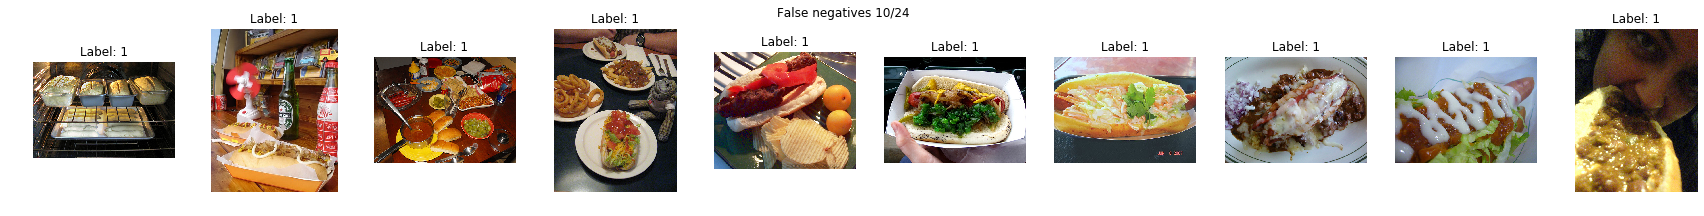

In [100]:
# Visualize false positives and false negatives of the best model on the validation set

false_positive_pointers, = np.nonzero((predictions == 1) & (ground_truth == 0))
false_positive_indices = np.array(val_indices)[false_positive_pointers]
visualize_samples(orig_train_dataset, false_positive_indices, "False positives")

false_negatives_pointers, = np.nonzero((predictions == 0) & (ground_truth == 1))
false_negatives_indices = np.array(val_indices)[false_negatives_pointers]
visualize_samples(orig_train_dataset, false_negatives_indices, "False negatives")